# CISC 451/839 Topics in Data Analytics 
## Course Project - Using Feature Engineering and Supervised Learning to Predict Game Results in Professional Hockey 
### Gavin McClelland - 10211444 
### Marshall Cunningham - 20249991

TODO: Fix this description

The objectives of this notebook are as follows: 
- Build on top of the previous approaches included in the midterm submission which featured extensive EDA and simple model construction to justify the validity of the project (not trivial to understand game results if information about the score is omitted)
- Using performance trends from previous games, aim to develop models to predict the result of a game before it happens
    - we are only concerned with the binary classification task of predicting wins and losses, not the condition of victory (such as winning in regulation, overtime, or in a shootout)

## Contents

The analytics process contained in this notebook is as follows:

1. Read-in Data
2. Create features in the range [0,1]
3. Min-Max normalization
4. Feature selection


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,plot_confusion_matrix,roc_curve,auc
from make_confusion_matrix import make_confusion_matrix
from plot_roc_curve import plot_roc_curve
from validate_model import validate_model
%cd "C:\Users\gmcclelland\Desktop\Misc School Stuff\repo\CISC451\project\data"
%matplotlib inline

C:\Users\gmcclelland\Desktop\Misc School Stuff\repo\CISC451\project\data


In [2]:
# Importing datasets, from the previous snapshot of work done for the midterm submission, and more sophisticated information from moneypuck.com 
# teams = pd.read_csv("teamstats_midterm.csv")
# adv_stats = pd.read_csv("moneypuck_teamstats2017-2018.csv")
# game_stats = pd.read_csv("moneypuck_allgames2017.csv")
game_stats = pd.read_csv("10seasons.csv")
team_stats = pd.read_csv('game_teams_stats.csv')

In [3]:
team_stats.drop(team_stats[team_stats.game_id > 2018000000].index, inplace=True)
team_stats = team_stats[['game_id', 'HoA', 'won']]
team_stats.rename(
    columns={
        "game_id": "gameId",
        "HoA": "home_or_away",
        "won": "WON"
    }, inplace=True
)
team_stats['home_or_away'] = team_stats['home_or_away'].str.upper()

game_stats = pd.merge(game_stats, team_stats,how='inner',on=['gameId','home_or_away'])

# Taking the result label from the team stats dataset
game_stats['WON'] = np.where(game_stats['WON'] == True, 1, 0)
game_stats.groupby('WON').size()

WON
0    9381
1    9361
dtype: int64

In [4]:
game_stats.drop(columns=['season',
                        'name',
                        'playerTeam',
                        'opposingTeam',
                        'gameDate',
                        'position',
                        'situation',
                        'iceTime',
                        'playoffGame'], inplace=True)                     
game_stats.head()

,team,gameId,home_or_away,xGoalsPercentage,corsiPercentage,fenwickPercentage,xOnGoalFor,xGoalsFor,xReboundsFor,xFreezeFor,...,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst,WON
0,TOR,2010020001,HOME,0.3191,0.4538,0.4342,23.965,1.469,1.480,5.820,...,43,42.078,5,0.562,0.806,0.806,2.891,2.899,2.774,1
1,MTL,2010020001,AWAY,0.6809,0.5462,0.5658,32.814,3.135,2.419,6.379,...,33,33.962,12,0.309,0.000,0.000,1.778,1.772,1.758,0
2,PIT,2010020002,HOME,0.4835,0.5603,0.5698,34.905,3.173,2.536,7.994,...,37,39.188,7,0.389,0.410,0.410,3.369,3.482,3.452,0
3,PHI,2010020002,AWAY,0.5165,0.4397,0.4302,26.012,3.390,1.782,5.868,...,49,46.974,3,0.552,0.318,0.318,3.406,3.287,3.225,1
4,MIN,2010020003,HOME,0.4120,0.4870,0.4805,28.668,2.644,2.152,6.873,...,40,42.408,5,0.428,0.908,0.908,3.292,3.472,3.391,0


In [5]:
# most features have a 'for' and 'against' pair, so we will combine them into a ratio in the range 0:1, which adds additional context to the game (i.e. which team had more shots on goal, etc.)
entries = []
for column in game_stats.columns.tolist():
    if column[-3:] == 'For':
        entries.append(column[:-3])
# NOTE: This took awhile to figure out, but if the stat has '0' in the for AND against columns, then the ratio will be null. If this is the case, we assign a ratio of 0.5 to each team with that gameId which provides a neutral, non-zero weight
for x in entries:
    game_stats[f'{x}Ratio'] = game_stats.apply(lambda row: row[f'{x}For'] / (row[f'{x}For'] + row[f'{x}Against']) if (row[f'{x}For'] + row[f'{x}Against']) != 0 else 0.5, axis=1)
    game_stats.drop(columns=[f'{x}For',f'{x}Against'],inplace=True)

In [6]:
# note that many of the probabalistic statistics (such as xGoalsPercentage) are not always a direct indicator of success. Teams with an xGoalsPercentage less than 50% still win games (roughly 20%)
game_stats.loc[(game_stats.xGoalsPercentage < 0.5) & (game_stats.WON == 1)].shape[0]

3463

In [7]:
cols_to_normalize = game_stats.drop(columns=['team','gameId','home_or_away','WON']).columns.tolist()
# Min-Max Normalization
for column in cols_to_normalize:
        game_stats[column] = (game_stats[column] - game_stats[column].min()) / (game_stats[column].max() - game_stats[column].min())
game_stats

,team,gameId,home_or_away,xGoalsPercentage,corsiPercentage,fenwickPercentage,WON,xOnGoalRatio,xGoalsRatio,xReboundsRatio,...,scoreAdjustedShotsAttemptsRatio,unblockedShotAttemptsRatio,scoreAdjustedUnblockedShotAttemptsRatio,dZoneGiveawaysRatio,xGoalsFromxReboundsOfShotsRatio,xGoalsFromActualReboundsOfShotsRatio,reboundxGoalsRatio,totalShotCreditRatio,scoreAdjustedTotalShotCreditRatio,scoreFlurryAdjustedTotalShotCreditRatio
0,TOR,2010020001,HOME,0.282520,0.421026,0.384073,1,0.363208,0.282488,0.310877,...,0.433891,0.384085,0.409142,0.705882,0.268453,0.000000,0.000000,0.342626,0.340433,0.351453
1,MTL,2010020001,AWAY,0.717480,0.578974,0.615927,0,0.636792,0.717512,0.689123,...,0.566109,0.615915,0.590858,0.294118,0.731547,1.000000,1.000000,0.657374,0.659567,0.648547
2,PIT,2010020002,HOME,0.480164,0.603077,0.622974,0,0.628134,0.480125,0.637126,...,0.558438,0.622924,0.576924,0.300000,0.638081,0.436813,0.436813,0.503605,0.480948,0.477473
3,PHI,2010020002,AWAY,0.519836,0.396923,0.377026,1,0.371866,0.519875,0.362874,...,0.441562,0.377076,0.423076,0.700000,0.361919,0.563187,0.563187,0.496395,0.519052,0.522527
4,MIN,2010020003,HOME,0.394205,0.477778,0.465645,0,0.470044,0.394244,0.537067,...,0.437429,0.465677,0.429371,0.500000,0.549767,0.190731,0.190731,0.459902,0.432858,0.433567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18737,VAN,2017021269,AWAY,0.526809,0.525470,0.525722,0,0.534239,0.526764,0.470607,...,0.547047,0.525659,0.544862,0.529412,0.489789,0.470156,0.470156,0.533316,0.556175,0.564338
18738,DAL,2017021270,AWAY,0.574657,0.221026,0.238196,1,0.246140,0.574682,0.356214,...,0.310713,0.238095,0.334534,0.461538,0.363252,0.777622,0.777622,0.441858,0.504536,0.496929
18739,L.A,2017021270,HOME,0.425343,0.778974,0.761804,0,0.753860,0.425318,0.643786,...,0.689287,0.761905,0.665466,0.538462,0.636748,0.222378,0.222378,0.558142,0.495464,0.503071
18740,MIN,2017021271,AWAY,0.577783,0.397436,0.323820,1,0.352376,0.577728,0.386562,...,0.465282,0.323810,0.392685,0.888889,0.371621,0.000000,0.000000,0.578462,0.621175,0.622651


In [8]:
# rearranging columns to beginning of df for organization purposes
cols = game_stats.drop(columns=['WON']).columns.tolist()
cols = ['WON'] + cols
game_stats = game_stats.reindex(columns=cols)
game_stats.head()

,WON,team,gameId,home_or_away,xGoalsPercentage,corsiPercentage,fenwickPercentage,xOnGoalRatio,xGoalsRatio,xReboundsRatio,...,scoreAdjustedShotsAttemptsRatio,unblockedShotAttemptsRatio,scoreAdjustedUnblockedShotAttemptsRatio,dZoneGiveawaysRatio,xGoalsFromxReboundsOfShotsRatio,xGoalsFromActualReboundsOfShotsRatio,reboundxGoalsRatio,totalShotCreditRatio,scoreAdjustedTotalShotCreditRatio,scoreFlurryAdjustedTotalShotCreditRatio
0,1,TOR,2010020001,HOME,0.282520,0.421026,0.384073,0.363208,0.282488,0.310877,...,0.433891,0.384085,0.409142,0.705882,0.268453,0.000000,0.000000,0.342626,0.340433,0.351453
1,0,MTL,2010020001,AWAY,0.717480,0.578974,0.615927,0.636792,0.717512,0.689123,...,0.566109,0.615915,0.590858,0.294118,0.731547,1.000000,1.000000,0.657374,0.659567,0.648547
2,0,PIT,2010020002,HOME,0.480164,0.603077,0.622974,0.628134,0.480125,0.637126,...,0.558438,0.622924,0.576924,0.300000,0.638081,0.436813,0.436813,0.503605,0.480948,0.477473
3,1,PHI,2010020002,AWAY,0.519836,0.396923,0.377026,0.371866,0.519875,0.362874,...,0.441562,0.377076,0.423076,0.700000,0.361919,0.563187,0.563187,0.496395,0.519052,0.522527
4,0,MIN,2010020003,HOME,0.394205,0.477778,0.465645,0.470044,0.394244,0.537067,...,0.437429,0.465677,0.429371,0.500000,0.549767,0.190731,0.190731,0.459902,0.432858,0.433567


## Approach #1 - Predicting the outcome using advanced statistics from the game (with no knowledge of the opponent)

### Feature Selection
We already have quite a few features (55), so before looking at previous games to predict the result of a game before it happens, let's find out which of these features are of any significance

In [9]:
gs_cpy = game_stats.copy()
game_stats.columns.tolist()

['WON',
 'team',
 'gameId',
 'home_or_away',
 'xGoalsPercentage',
 'corsiPercentage',
 'fenwickPercentage',
 'xOnGoalRatio',
 'xGoalsRatio',
 'xReboundsRatio',
 'xFreezeRatio',
 'xPlayStoppedRatio',
 'xPlayContinuedInZoneRatio',
 'xPlayContinuedOutsideZoneRatio',
 'flurryAdjustedxGoalsRatio',
 'scoreVenueAdjustedxGoalsRatio',
 'flurryScoreVenueAdjustedxGoalsRatio',
 'shotsOnGoalRatio',
 'missedShotsRatio',
 'blockedShotAttemptsRatio',
 'shotAttemptsRatio',
 'goalsRatio',
 'reboundsRatio',
 'reboundGoalsRatio',
 'freezeRatio',
 'playStoppedRatio',
 'playContinuedInZoneRatio',
 'playContinuedOutsideZoneRatio',
 'savedShotsOnGoalRatio',
 'savedUnblockedShotAttemptsRatio',
 'penaltiesRatio',
 'penalityMinutesRatio',
 'faceOffsWonRatio',
 'hitsRatio',
 'takeawaysRatio',
 'giveawaysRatio',
 'lowDangerShotsRatio',
 'mediumDangerShotsRatio',
 'highDangerShotsRatio',
 'lowDangerxGoalsRatio',
 'mediumDangerxGoalsRatio',
 'highDangerxGoalsRatio',
 'lowDangerGoalsRatio',
 'mediumDangerGoalsRatio',

### Feature Importance
Fitting a simple logistic regression model to our features to resolve feature "importances"

In [10]:
# Dropping categorical features, and also dropping goalsRatio, which explicitly represents the goals scored by each team
X = game_stats.drop(columns=['team','gameId','home_or_away','goalsRatio','WON']) 
Y = game_stats['WON']

In [11]:
lr = LogisticRegression()
lr.fit(X,Y)

LogisticRegression()

In [12]:
np.abs(lr.coef_[0])

array([ 0.05183391,  0.08481291,  3.24420141,  1.06866459,  0.05220198,
        2.69790134,  2.80768555,  0.5141652 ,  1.56913565,  5.04067954,
        2.61166421,  0.62371104,  1.90660164,  8.38969867,  3.08199232,
        2.87747703,  0.08526866,  0.24291018,  0.88375882,  2.52703428,
        0.55032869,  5.80956236,  4.7174342 , 14.7026683 , 13.36412386,
        0.11075318,  0.79498085,  0.21122763,  0.03562855,  0.73418353,
        0.43586432,  0.23416485,  0.58640132,  0.92918009,  0.15090168,
        2.01865924,  1.68454005,  3.90043665,  3.88559115,  2.81170205,
        3.83037566,  3.2462412 ,  6.43928776,  0.01859731,  3.81157649,
        0.3573142 ,  0.41960875,  1.67982246,  0.98724882,  2.91237739])

Below, we plot our feature coefficients in descending order to observe where a drop-off occurs

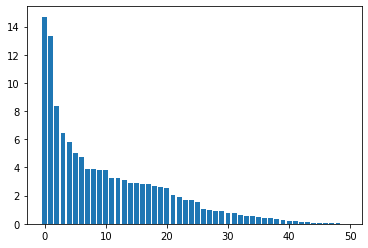

In [13]:
importance = np.abs(lr.coef_[0])
sorted_importance = -np.sort(-importance)
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(sorted_importance))], sorted_importance)
plt.show()

From the plot above, we are choosing the top 19 features as there is an observable drop-off in performance afterwards

Next, we find our columns to drop from our dataset, so we are left with our 19 most important features

In [14]:
cols_to_drop = []
thresh = sorted_importance[18]
for n,val in enumerate(importance):
    print(val)
    if val < thresh:
        cols_to_drop.append(game_stats.columns[n+4])
game_stats.drop(cols_to_drop,axis=1,inplace=True)

0.05183391011581566
0.0848129079033411
3.244201413426001
1.0686645943794597
0.05220197532134495
2.6979013442353055
2.8076855484744216
0.5141651998444977
1.5691356496957074
5.040679541854149
2.6116642108531365
0.6237110361982915
1.9066016364960594
8.38969867221306
3.081992321683534
2.8774770296410046
0.08526865627332832
0.24291018045036206
0.8837588189993378
2.5270342825687244
0.5503286906548845
5.8095623638277445
4.71743420251917
14.702668301438798
13.364123860564323
0.11075318135891875
0.7949808470351664
0.21122763461432387
0.03562855338500015
0.7341835325961116
0.4358643205627438
0.23416485227130956
0.586401324110017
0.9291800908025337
0.1509016848170383
2.018659239974545
1.6845400483934483
3.900436653398593
3.8855911547222415
2.8117020505324666
3.8303756567296814
3.2462412014962365
6.43928776151323
0.018597313562486107
3.8115764865302846
0.35731420377432005
0.4196087524838064
1.6798224559883834
0.9872488230026447
2.91237739191171


In [15]:
# Verifying that feature selection worked as expected
print(cols_to_drop)

['xGoalsPercentage', 'corsiPercentage', 'xOnGoalRatio', 'xGoalsRatio', 'xPlayStoppedRatio', 'xPlayContinuedInZoneRatio', 'flurryAdjustedxGoalsRatio', 'scoreVenueAdjustedxGoalsRatio', 'flurryScoreVenueAdjustedxGoalsRatio', 'shotAttemptsRatio', 'goalsRatio', 'reboundsRatio', 'reboundGoalsRatio', 'freezeRatio', 'savedUnblockedShotAttemptsRatio', 'penaltiesRatio', 'penalityMinutesRatio', 'faceOffsWonRatio', 'hitsRatio', 'takeawaysRatio', 'giveawaysRatio', 'lowDangerShotsRatio', 'mediumDangerShotsRatio', 'highDangerShotsRatio', 'lowDangerxGoalsRatio', 'mediumDangerxGoalsRatio', 'scoreAdjustedUnblockedShotAttemptsRatio', 'xGoalsFromxReboundsOfShotsRatio', 'xGoalsFromActualReboundsOfShotsRatio', 'reboundxGoalsRatio', 'totalShotCreditRatio']


Next, we create a correlation heatmap to visualize any redundant/synonymous features, along with those that are too highly correlated with the outcome label 'WON'

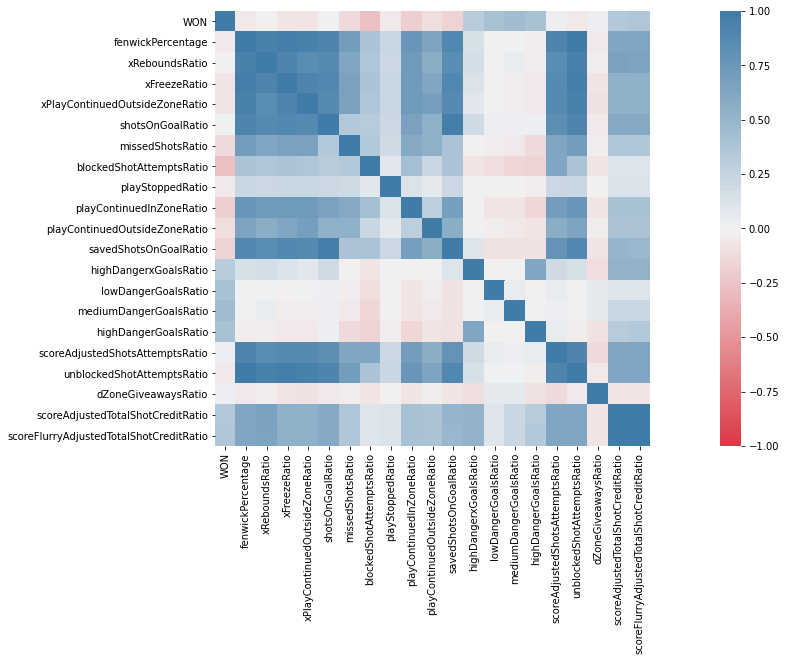

In [16]:
corr = game_stats.drop(columns=['team','gameId','home_or_away']).corr()
fig, ax = plt.subplots(figsize=(25,8)) 
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1,
    square=True,
    cmap=sns.diverging_palette(10,240,n=100),
    ax=ax
)

The only duplicate features are different versions of the same stat, which can be seen near the bottom (different versions of shotCredit)
- So, we keep the flurry adjusted stat as flurry is more repeatable and regarded as having more predictive power (see report)

In [17]:
game_stats.drop(columns=['scoreAdjustedTotalShotCreditRatio'],inplace=True)

In [18]:
# dimensions of the dataset after selecting features
game_stats.shape

(18742, 23)

In [19]:
from sklearn import svm
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.metrics import accuracy_score
feat = game_stats.drop(columns=['team','home_or_away','gameId','WON'])
label = game_stats['WON']
x_train,x_test,y_train,y_test = train_test_split(feat,label,test_size=0.2) # test on 20% of dataset 
clf = svm.SVC(kernel='linear', C=1)
scores = cross_validate(clf, x_train, y_train, scoring='accuracy',cv=10,return_estimator=True)

In [20]:
best_score = np.argmax(scores['test_score'])
estimators = scores['estimator']
clf = estimators[best_score]
pred = clf.predict(x_test)
accuracy_score(y_test,pred)

0.9010402774073086

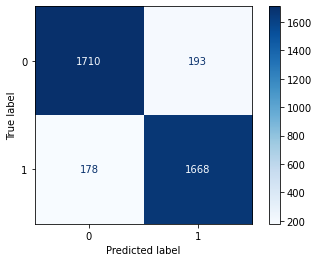

In [21]:
plot_confusion_matrix(clf,x_test,y_test,cmap=plt.cm.Blues)

In [22]:
lrc = LogisticRegression()
knnc = KNeighborsClassifier() # defaults to 5-NN
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()

group_names = ["True Neg","False Pos","False Neg","True Pos"]
categories = ["Lost", "Won"]

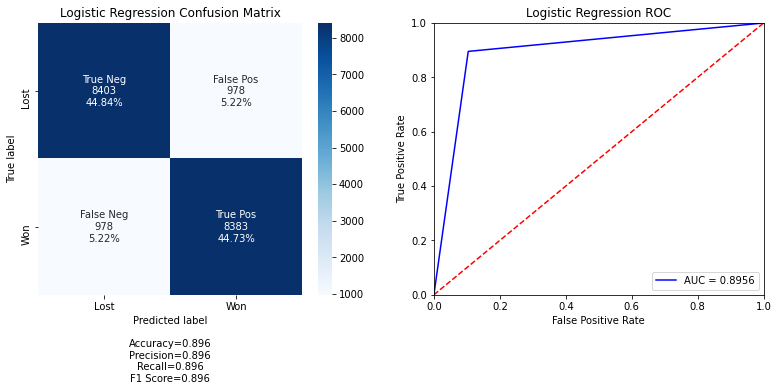

<Figure size 432x288 with 0 Axes>

In [23]:
validate_model(lrc, feat, label, 'Logistic Regression', group_names=group_names, categories=categories)

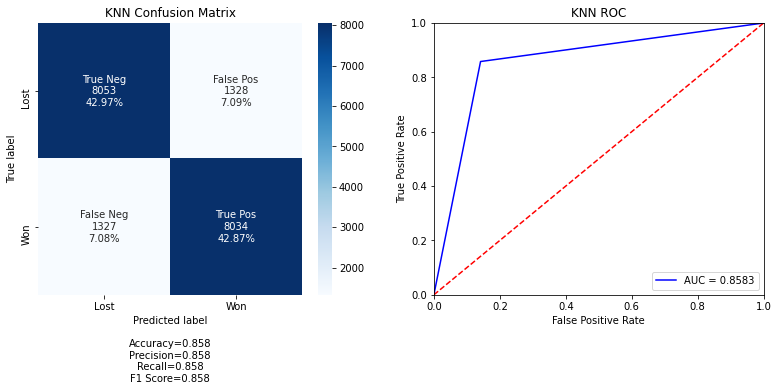

<Figure size 432x288 with 0 Axes>

In [24]:
validate_model(knnc, feat, label, 'KNN', group_names=group_names, categories=categories)

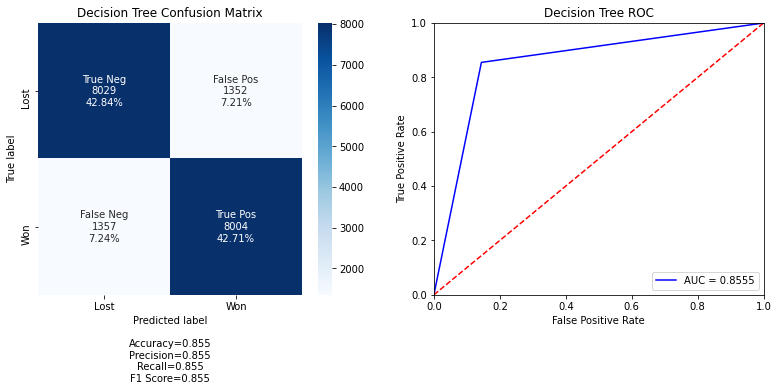

<Figure size 432x288 with 0 Axes>

In [25]:
validate_model(dtc, feat, label, 'Decision Tree', group_names=group_names, categories=categories)

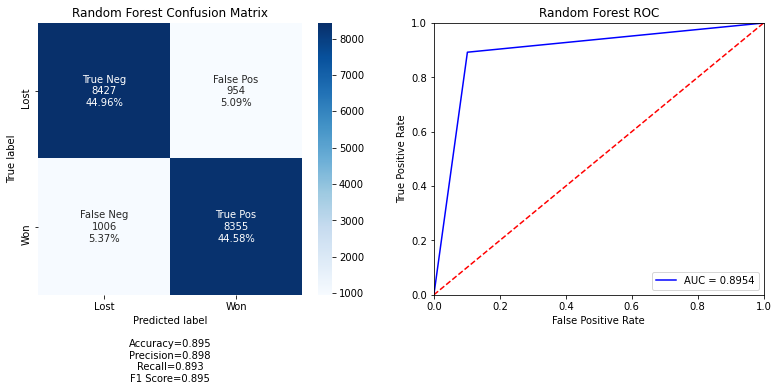

<Figure size 432x288 with 0 Axes>

In [26]:
validate_model(rfc, feat, label, 'Random Forest', group_names=group_names, categories=categories)

## Approach #2: Creating Historical Features (again, with no knowledge of the opponent)
With the objective of predicting outcome before a game has occurred, it is important to have information about the team **before** the game takes place
- So, below we create rolling averages from the previous 1, and 3 games not including the current game. This will create historical versions of the previously selected features for training our models

In [27]:
gs_cpy # using the deep copy of the dataframe created prior to feature selection in approach #1

,WON,team,gameId,home_or_away,xGoalsPercentage,corsiPercentage,fenwickPercentage,xOnGoalRatio,xGoalsRatio,xReboundsRatio,...,scoreAdjustedShotsAttemptsRatio,unblockedShotAttemptsRatio,scoreAdjustedUnblockedShotAttemptsRatio,dZoneGiveawaysRatio,xGoalsFromxReboundsOfShotsRatio,xGoalsFromActualReboundsOfShotsRatio,reboundxGoalsRatio,totalShotCreditRatio,scoreAdjustedTotalShotCreditRatio,scoreFlurryAdjustedTotalShotCreditRatio
0,1,TOR,2010020001,HOME,0.282520,0.421026,0.384073,0.363208,0.282488,0.310877,...,0.433891,0.384085,0.409142,0.705882,0.268453,0.000000,0.000000,0.342626,0.340433,0.351453
1,0,MTL,2010020001,AWAY,0.717480,0.578974,0.615927,0.636792,0.717512,0.689123,...,0.566109,0.615915,0.590858,0.294118,0.731547,1.000000,1.000000,0.657374,0.659567,0.648547
2,0,PIT,2010020002,HOME,0.480164,0.603077,0.622974,0.628134,0.480125,0.637126,...,0.558438,0.622924,0.576924,0.300000,0.638081,0.436813,0.436813,0.503605,0.480948,0.477473
3,1,PHI,2010020002,AWAY,0.519836,0.396923,0.377026,0.371866,0.519875,0.362874,...,0.441562,0.377076,0.423076,0.700000,0.361919,0.563187,0.563187,0.496395,0.519052,0.522527
4,0,MIN,2010020003,HOME,0.394205,0.477778,0.465645,0.470044,0.394244,0.537067,...,0.437429,0.465677,0.429371,0.500000,0.549767,0.190731,0.190731,0.459902,0.432858,0.433567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18737,0,VAN,2017021269,AWAY,0.526809,0.525470,0.525722,0.534239,0.526764,0.470607,...,0.547047,0.525659,0.544862,0.529412,0.489789,0.470156,0.470156,0.533316,0.556175,0.564338
18738,1,DAL,2017021270,AWAY,0.574657,0.221026,0.238196,0.246140,0.574682,0.356214,...,0.310713,0.238095,0.334534,0.461538,0.363252,0.777622,0.777622,0.441858,0.504536,0.496929
18739,0,L.A,2017021270,HOME,0.425343,0.778974,0.761804,0.753860,0.425318,0.643786,...,0.689287,0.761905,0.665466,0.538462,0.636748,0.222378,0.222378,0.558142,0.495464,0.503071
18740,1,MIN,2017021271,AWAY,0.577783,0.397436,0.323820,0.352376,0.577728,0.386562,...,0.465282,0.323810,0.392685,0.888889,0.371621,0.000000,0.000000,0.578462,0.621175,0.622651


In [28]:
window_lengths = (1, 3)
new_cols = ['team','home_or_away','gameId']

for col in gs_cpy.columns:
    if col in new_cols:
        continue
    if col == 'WON':
        new_cols.append(col)
    for length in window_lengths:
        new_cols.append(f'{col}Prev{length}')
new_df = pd.DataFrame(columns=new_cols)
for team in gs_cpy.team.sort_values(ascending=True).unique().tolist():
    # print(team)
    df = gs_cpy.loc[gs_cpy['team'] == team]
    # print(df)
    df.sort_values('gameId', ascending=True, inplace=True)
    for col in df.columns:
        if col != 'WON' and col in new_cols:
            continue
        for length in window_lengths:
            df[f'{col}Prev{length}'] = df[col].rolling(length).mean().shift(1) # shift one record up so the current game is not included
        if col != 'WON':
            df.drop(col, axis=1, inplace=True)
    new_df = pd.concat([new_df, df])
# new_df.sort_values('gameId', ascending=True, inplace=True)

In [29]:
new_df.shape

(18742, 108)

In [30]:
# We need to handle NaN's here by dropping the first five games each team plays so the historical features can take effect
new_df.dropna(inplace=True)

In [31]:
new_df

,team,home_or_away,gameId,WON,WONPrev1,WONPrev3,xGoalsPercentagePrev1,xGoalsPercentagePrev3,corsiPercentagePrev1,corsiPercentagePrev3,...,xGoalsFromActualReboundsOfShotsRatioPrev1,xGoalsFromActualReboundsOfShotsRatioPrev3,reboundxGoalsRatioPrev1,reboundxGoalsRatioPrev3,totalShotCreditRatioPrev1,totalShotCreditRatioPrev3,scoreAdjustedTotalShotCreditRatioPrev1,scoreAdjustedTotalShotCreditRatioPrev3,scoreFlurryAdjustedTotalShotCreditRatioPrev1,scoreFlurryAdjustedTotalShotCreditRatioPrev3
80,ANA,HOME,2010020041,1,0.0,0.000000,0.061193,0.245492,0.044615,0.235726,...,0.017017,0.125811,0.017017,0.125811,0.064582,0.271394,0.061508,0.269048,0.074276,0.274134
104,ANA,HOME,2010020053,0,1.0,0.333333,0.314980,0.219083,0.409744,0.281140,...,0.371278,0.137914,0.371278,0.137914,0.315991,0.247575,0.292864,0.240552,0.304908,0.250481
132,ANA,HOME,2010020067,1,0.0,0.333333,0.484011,0.286728,0.630940,0.361766,...,0.357728,0.248674,0.357728,0.248674,0.556548,0.312373,0.543680,0.299351,0.533439,0.304207
156,ANA,AWAY,2010020079,0,1.0,0.666667,0.496994,0.431995,0.424957,0.488547,...,0.237500,0.322169,0.237500,0.322169,0.543377,0.471972,0.534213,0.456919,0.533341,0.457229
167,ANA,AWAY,2010020084,1,0.0,0.333333,0.407550,0.462852,0.737949,0.597949,...,1.000000,0.531743,1.000000,0.531743,0.437430,0.512452,0.446709,0.508201,0.441124,0.502635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18602,WSH,HOME,2017021202,0,1.0,1.000000,0.436283,0.533141,0.493162,0.475613,...,0.178841,0.316610,0.178841,0.316610,0.465415,0.557463,0.444270,0.576708,0.444505,0.583738
18641,WSH,AWAY,2017021221,1,0.0,0.666667,0.390478,0.411557,0.475043,0.450199,...,0.222683,0.174943,0.222683,0.174943,0.427664,0.447045,0.395881,0.447792,0.392139,0.451791
18651,WSH,AWAY,2017021226,1,1.0,0.666667,0.526208,0.450990,0.485299,0.484501,...,0.371566,0.257697,0.371566,0.257697,0.574764,0.489281,0.599872,0.480008,0.602960,0.479868
18686,WSH,HOME,2017021244,0,1.0,0.666667,0.529574,0.482087,0.369060,0.443134,...,0.252366,0.282205,0.252366,0.282205,0.535866,0.512765,0.575121,0.523624,0.601835,0.532311


In [32]:
cols_to_normalize = new_df.drop(columns=['team','gameId','home_or_away','WON']).columns.tolist()
# Normalizing the range of all columns once again using min-max
for column in cols_to_normalize:
    new_df[column] = (new_df[column] - new_df[column].min()) / (new_df[column].max() - new_df[column].min())

In [33]:
new_df

,team,home_or_away,gameId,WON,WONPrev1,WONPrev3,xGoalsPercentagePrev1,xGoalsPercentagePrev3,corsiPercentagePrev1,corsiPercentagePrev3,...,xGoalsFromActualReboundsOfShotsRatioPrev1,xGoalsFromActualReboundsOfShotsRatioPrev3,reboundxGoalsRatioPrev1,reboundxGoalsRatioPrev3,totalShotCreditRatioPrev1,totalShotCreditRatioPrev3,scoreAdjustedTotalShotCreditRatioPrev1,scoreAdjustedTotalShotCreditRatioPrev3,scoreFlurryAdjustedTotalShotCreditRatioPrev1,scoreFlurryAdjustedTotalShotCreditRatioPrev3
80,ANA,HOME,2010020041,1,0.0,0.000000,0.061193,0.076238,0.044615,0.150492,...,0.017017,0.125811,0.017017,0.125811,0.064582,0.160681,0.061508,0.156823,0.074276,0.165854
104,ANA,HOME,2010020053,0,1.0,0.333333,0.314980,0.033113,0.409744,0.217574,...,0.371278,0.137914,0.371278,0.137914,0.315991,0.121915,0.292864,0.110391,0.304908,0.127219
132,ANA,HOME,2010020067,1,0.0,0.333333,0.484011,0.143577,0.630940,0.336672,...,0.357728,0.248674,0.357728,0.248674,0.556548,0.227379,0.543680,0.206199,0.533439,0.214976
156,ANA,AWAY,2010020079,0,1.0,0.666667,0.496994,0.380800,0.424957,0.523946,...,0.237500,0.322169,0.237500,0.322169,0.543377,0.487141,0.534213,0.462946,0.533341,0.464925
167,ANA,AWAY,2010020084,1,0.0,0.333333,0.407550,0.431189,0.737949,0.685548,...,1.000000,0.531743,1.000000,0.531743,0.437430,0.553025,0.446709,0.546506,0.441124,0.539091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18602,WSH,HOME,2017021202,0,1.0,1.000000,0.436283,0.545972,0.493162,0.504840,...,0.178841,0.316610,0.178841,0.316610,0.465415,0.626285,0.444270,0.658134,0.444505,0.671567
18641,WSH,AWAY,2017021221,1,0.0,0.666667,0.390478,0.347425,0.475043,0.467301,...,0.222683,0.174943,0.222683,0.174943,0.427664,0.446570,0.395881,0.448074,0.392139,0.456041
18651,WSH,AWAY,2017021226,1,1.0,0.666667,0.526208,0.411819,0.485299,0.517970,...,0.371566,0.257697,0.371566,0.257697,0.574764,0.515313,0.599872,0.500567,0.602960,0.501904
18686,WSH,HOME,2017021244,0,1.0,0.666667,0.529574,0.462601,0.369060,0.456864,...,0.252366,0.282205,0.252366,0.282205,0.535866,0.553535,0.575121,0.571637,0.601835,0.587566


In [34]:
# Dropping categorical features
X2 = new_df.drop(columns=['team','gameId','home_or_away','WON'])
new_df['WON'] = new_df['WON'].astype('int')
Y2 = new_df['WON']

In [35]:
lr2 = LogisticRegression()
lr2.fit(X2,Y2)

LogisticRegression()

In [36]:
np.abs(lr2.coef_[0])

array([5.62334331e-02, 1.28754638e-02, 5.02100186e-02, 9.25109002e-02,
       1.49320733e-01, 4.68331573e-03, 2.52606327e-02, 1.28084307e-01,
       4.17109407e-02, 3.01509213e-01, 5.04340197e-02, 9.34845772e-02,
       1.64709632e-01, 2.22803848e-01, 2.71402026e-01, 2.96582390e-01,
       1.95962398e-01, 4.85309152e-01, 2.26055870e-01, 3.48724920e-02,
       3.76472863e-01, 2.79646698e-01, 1.90652651e-01, 2.05825186e-01,
       1.45829878e-01, 1.63667308e-01, 3.02612170e-01, 4.76437856e-01,
       2.57316234e-01, 4.47857180e-01, 3.53120538e-01, 4.59777348e-01,
       2.33376671e-01, 1.22763235e-01, 1.50537680e-01, 3.43997110e-03,
       1.60586109e-01, 1.11965697e-01, 4.47640996e-04, 3.58633892e-01,
       7.86181950e-02, 1.55909507e-01, 1.26556049e-01, 1.59178217e-03,
       3.82405396e-02, 5.42170428e-02, 2.82171676e-01, 2.84583509e-01,
       5.10955919e-02, 7.63470239e-02, 2.53945876e-01, 6.50564355e-01,
       1.31795254e-01, 2.56664699e-02, 1.74189711e-01, 9.13946240e-02,
      

Once again, we plot our feature coefficients in descending order to observe where a drop-off occurs

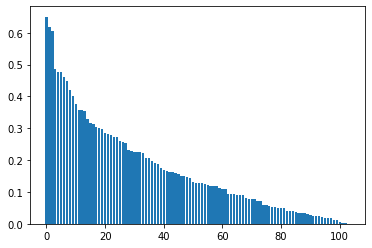

In [37]:
imp2 = np.abs(lr2.coef_[0])
imp2sorted = -np.sort(-imp2)
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(imp2sorted))], imp2sorted)
plt.show()

From the plot above (which looks rather strange), we choose the top 20 features as there is an observable drop-off in performance afterwards

Next, we find our columns to drop from our dataset, so we are left with our 20 most important features

In [38]:
cols_to_drop = []
thresh = imp2sorted[20]
print(f'Threshold: {thresh}')
for n,val in enumerate(imp2):
    if val < thresh:
        print(val)
        cols_to_drop.append(new_df.columns[n+4])
new_df.drop(cols_to_drop,axis=1,inplace=True)

# Verifying that feature selection worked as expected
print(cols_to_drop)

Threshold: 0.2845835085465376
0.05623343311046585
0.012875463838544054
0.05021001861224386
0.09251090017026754
0.14932073278625838
0.004683315730661737
0.0252606326627794
0.12808430717676916
0.04171094069926537
0.050434019658678234
0.09348457723319875
0.16470963192281549
0.22280384802009107
0.27140202610866
0.19596239796907294
0.22605586972709105
0.03487249204193606
0.27964669842396866
0.19065265116679528
0.20582518640424763
0.1458298775512063
0.1636673080524158
0.25731623358639316
0.2333766711799358
0.12276323462974499
0.15053768036517054
0.003439971095849811
0.16058610933295658
0.11196569675833747
0.0004476409955827983
0.0786181950094721
0.15590950656736763
0.12655604881012658
0.0015917821655512085
0.03824053956690735
0.05421704278204045
0.28217167627342715
0.05109559190556839
0.07634702388470888
0.25394587568290555
0.13179525435392497
0.025666469916223452
0.1741897107776125
0.09139462402485184
0.017444870344453238
0.1188516526943623
0.12851071934938466
0.11925188457619747
0.09011822

And as before, we create a correlation heatmap to visualize any redundant/synonymous features

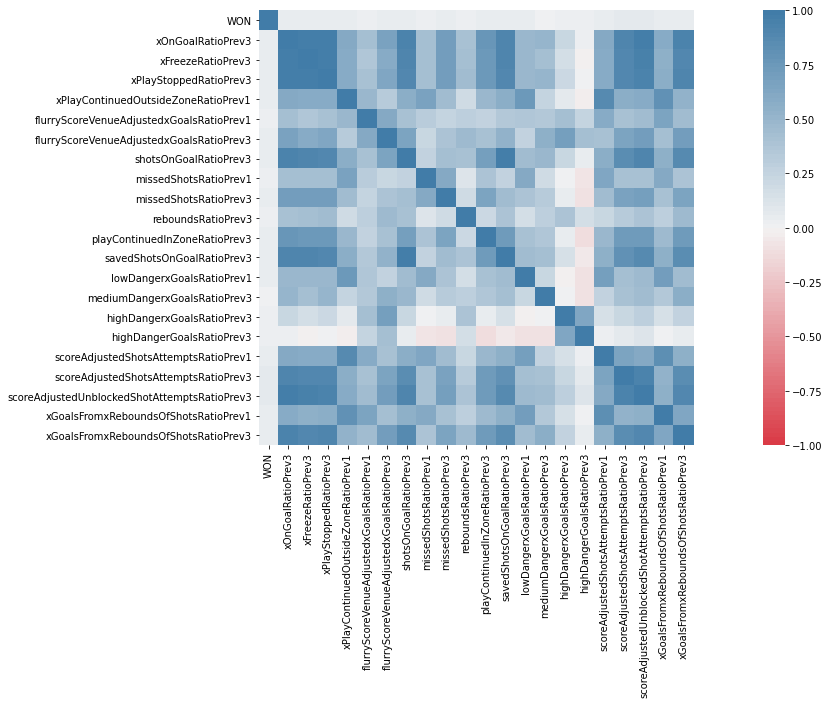

In [39]:
corr = new_df.drop(columns=['team','gameId','home_or_away']).corr()
fig, ax = plt.subplots(figsize=(25,8)) 
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1,
    square=True,
    cmap=sns.diverging_palette(10,240,n=100),
    ax=ax
)

In [40]:
# dimensions of the dataset after selecting features
new_df.shape

(18646, 25)

In [65]:
# Cross-validating a simple SVM using an 80/20 training/validation split and 10-fold to find a good estimator
from sklearn import svm
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.metrics import accuracy_score
feat = new_df.drop(columns=['team','home_or_away','gameId','WON'])
label = new_df['WON']
x_train,x_test,y_train,y_test = train_test_split(feat,label,test_size=0.2) # test on 20% of dataset 
clf = svm.SVC(kernel='linear', C=1)
scores = cross_validate(clf, x_train, y_train, scoring='roc_auc',cv=10,return_estimator=True)
scores['test_score']

array([0.55360952, 0.52583668, 0.52894711, 0.5162081 , 0.51564926,
       0.54073407, 0.52723618, 0.55650199, 0.52657944, 0.54966641])

In [66]:
# Let's find our best estimator. Since cross_validate returns a dict of estimators and their scores, we can find the index of the estimator containing the best score, and use it to predict against the test set
best_score = np.argmax(scores['test_score'])
estimators = scores['estimator']
clf = estimators[best_score]
pred = clf.predict(x_test)
accuracy_score(y_test,pred)

0.546916890080429

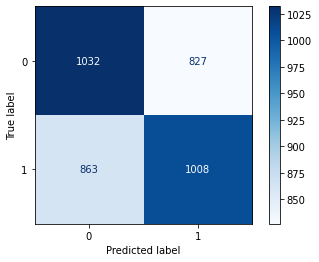

In [67]:
plot_confusion_matrix(clf,x_test,y_test,cmap=plt.cm.Blues)

Well, that's not very good, let's try using PCA and see if performance improves

In [72]:
from sklearn.decomposition import PCA
pca = PCA(n_components=21) # one component for each numerical feature
pca.fit(x_train)
new_data_train = pca.transform(x_train)
new_data_test = pca.transform(x_test)
clf = svm.SVC(kernel='linear', C=1)
scores = cross_validate(clf, new_data_train, y_train, scoring='roc_auc',cv=10,return_estimator=True)
scores['test_score']

array([0.5536203 , 0.52580434, 0.52891476, 0.51620989, 0.51564566,
       0.54068196, 0.52726138, 0.5564948 , 0.52655245, 0.54974198])

In [78]:
new_data_train

array([[ 4.38953885e-01,  4.44600458e-01,  2.35013187e-01, ...,
         5.95817065e-03,  8.15739883e-03, -1.30601631e-02],
       [-8.14049924e-01, -9.25832871e-02,  9.33557923e-02, ...,
         1.14133016e-02, -6.55444283e-03, -3.37199680e-03],
       [-5.64689389e-02,  2.51823585e-02,  2.89462201e-02, ...,
        -1.07912688e-02,  2.28759132e-02,  1.73046815e-02],
       ...,
       [-3.58035674e-01, -2.12136062e-01, -1.29559236e-01, ...,
         2.95567223e-02, -1.10849559e-02, -3.19616197e-02],
       [ 3.93382172e-01,  4.86619366e-02, -2.90184413e-02, ...,
         1.23505750e-02,  2.80256948e-02,  7.28920405e-04],
       [-1.70062375e-01,  2.81587975e-01,  1.16818522e-01, ...,
        -1.01167238e-02,  5.12586754e-03, -9.41528985e-03]])

In [70]:
# Let's find our best estimator. Since cross_validate returns a dict of estimators and their scores, we can find the index of the estimator containing the best score, and use it to predict against the test set
best_score = np.argmax(scores['test_score'])
estimators = scores['estimator']
clf = estimators[best_score]
pred = clf.predict(new_data_test)
accuracy_score(y_test,pred)

0.5364611260053619

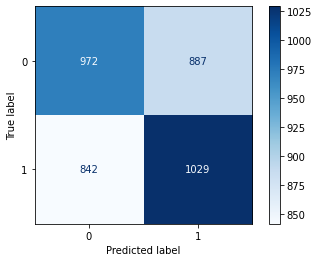

In [71]:
plot_confusion_matrix(clf,new_data_test,y_test,cmap=plt.cm.Blues)

This is still very poor--it's actually even worse--and I'm not sure why (I've tried everything I know how and the accuracy still hovers around 50/50 at best)

Let's see how other classifiers perform; anything around 55% is still pretty good using this type of data

In [80]:
lrc = LogisticRegression()
knnc = KNeighborsClassifier()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()

group_names = ["True Neg","False Pos","False Neg","True Pos"]
categories = ["Lost", "Won"]

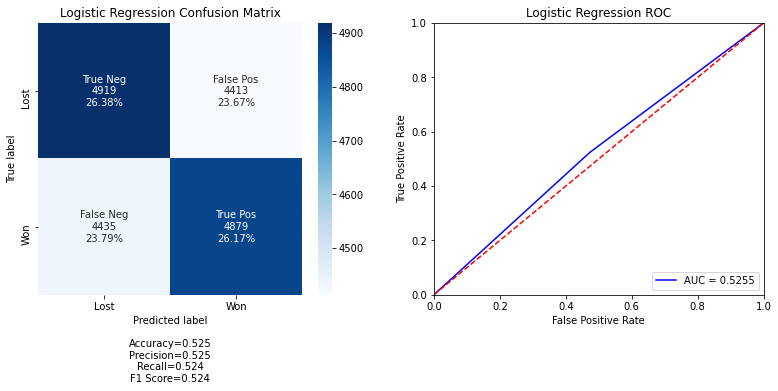

<Figure size 432x288 with 0 Axes>

In [74]:
validate_model(lrc, feat, label, 'Logistic Regression', group_names=group_names, categories=categories)

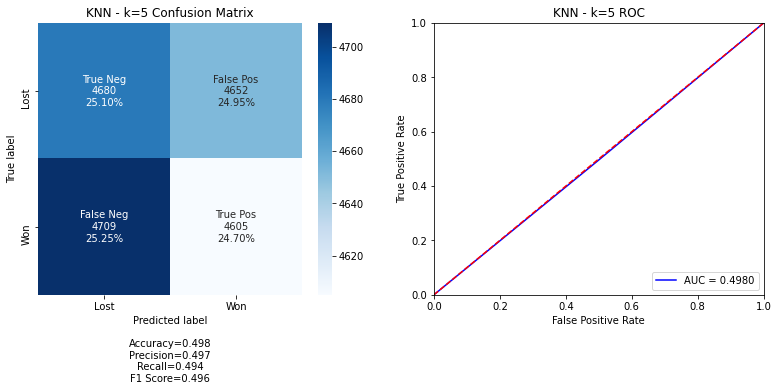

<Figure size 432x288 with 0 Axes>

In [75]:
validate_model(knnc, feat, label, 'KNN - k=5', group_names=group_names, categories=categories)

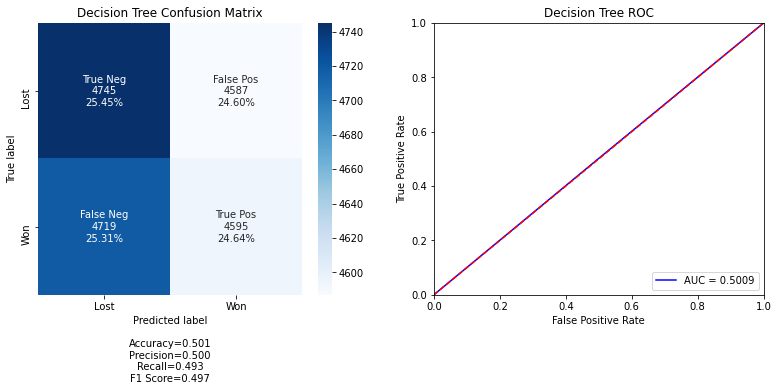

<Figure size 432x288 with 0 Axes>

In [76]:
validate_model(dtc, feat, label, 'Decision Tree', group_names=group_names, categories=categories)

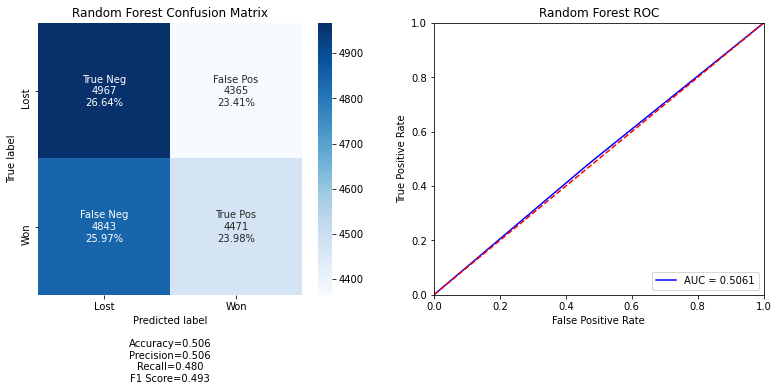

<Figure size 432x288 with 0 Axes>

In [77]:
validate_model(rfc, feat, label, 'Random Forest', group_names=group_names, categories=categories)

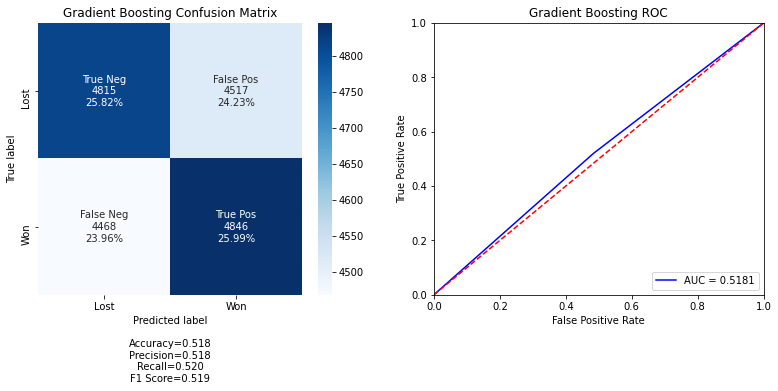

<Figure size 432x288 with 0 Axes>

In [81]:
validate_model(gbc, feat, label, 'Gradient Boosting', group_names=group_names, categories=categories)

This leads me to believe that our new features have nearly-zero predictive power, but while we're here, let's see if tuning hyperparameters makes even the slightest difference

In [83]:
from sklearn.model_selection import GridSearchCV

selected_model = gbc = GradientBoostingClassifier(min_samples_split=500, min_samples_leaf=50, max_depth=8, max_features='sqrt', subsample=0.8, random_state=10)

n_trees_search = GridSearchCV(estimator=selected_model, param_grid={'n_estimators':range(20,101,10)}, scoring='roc_auc', n_jobs=4, cv=5)
n_trees_search.fit(feat, label)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=8,
                                                  max_features='sqrt',
                                                  min_samples_leaf=50,
                                                  min_samples_split=500,
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=4, param_grid={'n_estimators': range(20, 101, 10)},
             scoring='roc_auc')

In [84]:
n_trees = n_trees_search.best_params_['n_estimators']

In [86]:
refined_gbc = GradientBoostingClassifier(min_samples_leaf=50, n_estimators=n_trees, max_features='sqrt', subsample=0.8, random_state=10)
depth_split_grid = {'max_depth': range(5,16,2), 'min_samples_split': range(200,1601,200)}
depth_split_test = GridSearchCV(estimator=refined_gbc , param_grid=depth_split_grid, scoring='roc_auc' ,n_jobs=-1, cv=5)
depth_split_test.fit(feat, label)
depth = depth_split_test.best_params_['max_depth']
split = depth_split_test.best_params_['min_samples_split']

In [89]:
refined_gbc = GradientBoostingClassifier(n_estimators=n_trees, min_samples_split=split, max_depth=depth, max_features='sqrt', subsample=0.8, random_state=10)
leaf_grid = {'min_samples_leaf':range(30,91,10)}
leaf_test = GridSearchCV(estimator=refined_gbc, param_grid=leaf_grid, scoring='roc_auc',n_jobs=-1,cv=5)
leaf_test.fit(feat,label)
leaf = leaf_test.best_params_['min_samples_leaf']

In [90]:
refined_gbc = GradientBoostingClassifier(n_estimators=n_trees, min_samples_split=split, max_depth=depth, min_samples_leaf=leaf, subsample=0.8, random_state=10)
features_grid = {'max_features':range(5,30,2)}
features_test = GridSearchCV(estimator=refined_gbc, param_grid=features_grid, scoring='roc_auc', n_jobs=-1, cv=5)
features_test.fit(feat, label)
features = features_test.best_params_['max_features']

In [93]:
refined_gbc = GradientBoostingClassifier(n_estimators=n_trees, min_samples_split=split, max_depth=depth, min_samples_leaf=leaf, max_features=features, random_state=10)
subsample_grid = {'subsample':[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]}
subsample_test = GridSearchCV(estimator=refined_gbc, param_grid=subsample_grid, scoring='roc_auc', n_jobs=-1, cv=5)
subsample_test.fit(feat,label)
subsample = subsample_test.best_params_['subsample']

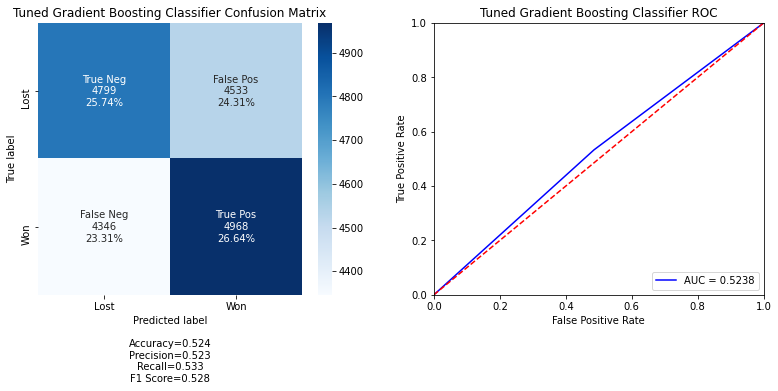

<Figure size 432x288 with 0 Axes>

In [95]:
tuned_model = GradientBoostingClassifier(learning_rate=0.001,n_estimators=100*n_trees, min_samples_split=split, max_depth=depth, min_samples_leaf=leaf, max_features=features, subsample=subsample, random_state=10)
validate_model(tuned_model, feat,label, 'Tuned Gradient Boosting Classifier', group_names=group_names, categories=categories)

Unfortunately, that's about as good as this approach is going to give us

In [27]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
feat = new_df.drop(columns=['team','home_or_away','gameId','WON'])
label = new_df['WON']

lr2 = LogisticRegression()
scores = cross_val_score(lr2, feat, label, cv=50)
print(scores)

x_train,x_test,y_train,y_test = train_test_split(feat,label,test_size=0.2) # test on 30% of dataset 
y_train = y_train.astype('int')
y_test = y_test.astype('int')
lr2.fit(x_train,y_train)
pred = lr2.predict(x_test)
print(accuracy_score(y_test,pred))

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
0.50418410041841


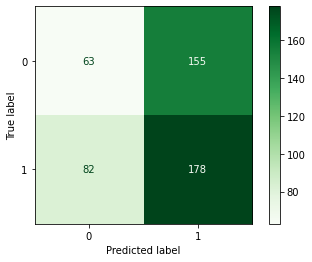

In [28]:
plot_confusion_matrix(lr2,x_test,y_test,cmap=plt.cm.Greens)

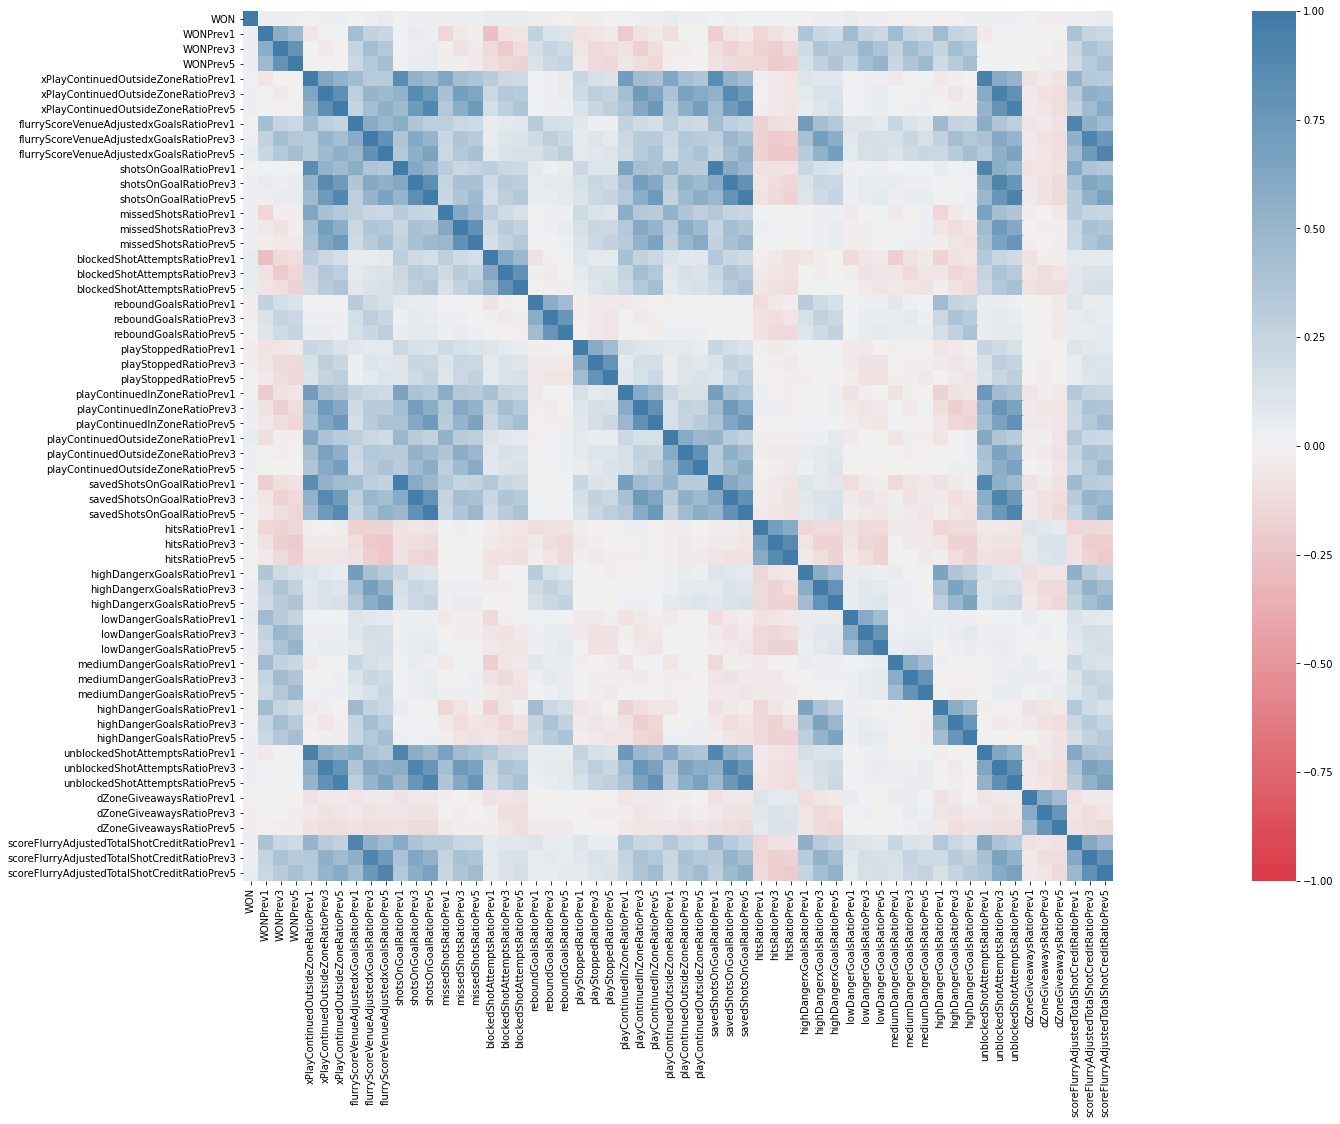

In [29]:
new_df.WON = new_df.WON.astype(int)
corr = new_df.drop(columns=['team','gameId','home_or_away']).corr()
fig, ax = plt.subplots(figsize=(50,16)) 
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1,
    square=True,
    cmap=sns.diverging_palette(10,240,n=100),
    ax=ax
)

In [30]:
corr.WON.sort_values(ascending=False)

WON                                             1.000000
playContinuedOutsideZoneRatioPrev1              0.054337
scoreFlurryAdjustedTotalShotCreditRatioPrev5    0.052837
flurryScoreVenueAdjustedxGoalsRatioPrev5        0.049275
lowDangerGoalsRatioPrev1                        0.040945
blockedShotAttemptsRatioPrev5                   0.040865
blockedShotAttemptsRatioPrev3                   0.040457
blockedShotAttemptsRatioPrev1                   0.040343
missedShotsRatioPrev5                           0.039347
scoreFlurryAdjustedTotalShotCreditRatioPrev3    0.038468
playContinuedOutsideZoneRatioPrev3              0.037478
highDangerxGoalsRatioPrev5                      0.035730
playContinuedOutsideZoneRatioPrev5              0.035437
playContinuedInZoneRatioPrev5                   0.035296
unblockedShotAttemptsRatioPrev5                 0.034586
unblockedShotAttemptsRatioPrev3                 0.034051
flurryScoreVenueAdjustedxGoalsRatioPrev3        0.033252
xPlayContinuedOutsideZoneRatioP

In [31]:
corr.describe()

,WON,WONPrev1,WONPrev3,WONPrev5,xPlayContinuedOutsideZoneRatioPrev1,xPlayContinuedOutsideZoneRatioPrev3,xPlayContinuedOutsideZoneRatioPrev5,flurryScoreVenueAdjustedxGoalsRatioPrev1,flurryScoreVenueAdjustedxGoalsRatioPrev3,flurryScoreVenueAdjustedxGoalsRatioPrev5,...,highDangerGoalsRatioPrev5,unblockedShotAttemptsRatioPrev1,unblockedShotAttemptsRatioPrev3,unblockedShotAttemptsRatioPrev5,dZoneGiveawaysRatioPrev1,dZoneGiveawaysRatioPrev3,dZoneGiveawaysRatioPrev5,scoreFlurryAdjustedTotalShotCreditRatioPrev1,scoreFlurryAdjustedTotalShotCreditRatioPrev3,scoreFlurryAdjustedTotalShotCreditRatioPrev5
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,...,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,0.034023,0.101321,0.118635,0.115454,0.270551,0.317654,0.307095,0.257596,0.308031,0.305599,...,0.098707,0.291844,0.340097,0.327237,0.006274,0.004136,-0.015516,0.254241,0.303146,0.301755
std,0.131144,0.231666,0.257995,0.251807,0.294062,0.328073,0.323403,0.234132,0.258967,0.262162,...,0.245799,0.302749,0.333743,0.330881,0.172815,0.196365,0.195047,0.231612,0.258566,0.263570
min,-0.039441,-0.275333,-0.209778,-0.205806,-0.089996,-0.109633,-0.114682,-0.178876,-0.213543,-0.239009,...,-0.178616,-0.091986,-0.110128,-0.119962,-0.116711,-0.132849,-0.142408,-0.156280,-0.181446,-0.205497
25%,0.003922,-0.056278,-0.084792,-0.056200,0.000895,0.014081,0.018481,0.095518,0.144151,0.146557,...,-0.060768,0.009268,0.028315,0.031269,-0.054253,-0.076576,-0.106092,0.099008,0.130459,0.135548
50%,0.023891,0.013706,0.007849,0.015702,0.222295,0.289780,0.259432,0.238473,0.305674,0.310994,...,0.004205,0.244439,0.313570,0.295932,-0.036369,-0.040970,-0.064686,0.235583,0.310282,0.269604
75%,0.034452,0.241481,0.307541,0.269713,0.463843,0.594518,0.550556,0.372108,0.430346,0.448948,...,0.223539,0.507068,0.623463,0.588956,-0.003746,-0.010396,-0.018217,0.357931,0.435203,0.453219
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
